# <center> **Project 3 Booking Timur**

In [207]:
#Импортн необходимых библиотек
import pandas as pd
import numpy as np
import plotly as px
import collections as coll
import seaborn as sns
import statistics
import os
import warnings
import re
import nltk
import string

import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

# Импортируем необходимые библиотеки:
from sklearn.feature_selection import f_classif

from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# библиотека для расчетов
from scipy import stats

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

#EDA одной строкой кода
from pandas_profiling import ProfileReport

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [208]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# <center> **0. ПОСТАНОВКА ПРОБЛЕМЫ**

## <center> **КАКОЙ КЕЙС РЕШАЕМ?**
    
Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

### **КРИТЕРИИ**
* Очистка данных.
* Исследование данных (качество визуализации, наличие идей, гипотез, комментариев).
* Генерация признаков.
* Отбор признаков.
* Преобразование признаков.
* Качество решения: результат метрики MAPE.

# <center> **1. СБОР ДАННЫХ**

In [209]:
# Импорт дада сета
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [210]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [211]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

print("Train shape : ", df_test.shape)
print("Test shape : ", df_train.shape)
print("Data shape:", data.shape)
print("Sample_submission shape:", sample_submission.shape)

Train shape :  (128935, 18)
Test shape :  (386803, 18)
Data shape: (515738, 18)
Sample_submission shape: (128935, 2)


In [212]:
print("\nПроверка данных:\n")
print("\nДатасет для обучения:\n")
display(df_train[:1])
print("\nДатасет для предсказания:\n")
display(df_test[:1])
print("\nОбъеденённый дасет:\n")
display(data[:1])


Проверка данных:


Датасет для обучения:



hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   

           hotel_name reviewer_nationality negative_review  \
0  The May Fair Hotel      United Kingdom         Leaving    

   review_total_negative_word_counts  total_number_of_reviews  \
0                                  3                     1994   

       positive_review  review_total_positive_word_counts  \
0   Staff were amazing                                  4   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   

         lat       lng  sample  
0  51.507894 -0.143671       1


Датасет для предсказания:



hotel_address  additional_number_of_scoring  \
0  Via Senigallia 6 20161 Milan Italy                           904   

  review_date  average_score      hotel_name reviewer_nationality  \
0   7/21/2017            8.1  Hotel Da Vinci      United Kingdom    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   

   review_total_positive_word_counts  \
0                                 62   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   

         lat       lng  sample  reviewer_score  
0  45.533137  9.171102       0               0


Объеденённый дасет:



hotel_address  additional_number_of_scoring  \
0  Via Senigallia 6 20161 Milan Italy                           904   

  review_date  average_score      hotel_name reviewer_nationality  \
0   7/21/2017            8.1  Hotel Da Vinci      United Kingdom    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   

   review_total_positive_word_counts  \
0                                 62   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   

         lat       lng  sample  reviewer_score  
0  45.533137  9.171102       0             0.0

In [213]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [214]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

### <center> **Типы данных**

In [215]:
print("\nТипы данных:\n")
data.dtypes.value_counts()


Типы данных:



object     8
int64      6
float64    4
dtype: int64

In [216]:
print("\nТип данных int64:\n")
data.dtypes[df_train.dtypes=='int64']


Тип данных int64:



additional_number_of_scoring                  int64
review_total_negative_word_counts             int64
total_number_of_reviews                       int64
review_total_positive_word_counts             int64
total_number_of_reviews_reviewer_has_given    int64
sample                                        int64
dtype: object

In [217]:
print("\nТип данных float64:\n")
data.dtypes[data.dtypes=='float']


Тип данных float64:



average_score     float64
lat               float64
lng               float64
reviewer_score    float64
dtype: object

In [218]:
print("\nТип данных object:\n")
data.dtypes[data.dtypes=='object ']


Тип данных object:



Series([], dtype: object)

In [219]:
print("\nData shape:\n")
print(data.shape)

print("\nПросмотр форм & типы данных данных:\n")
print(data.dtypes)

print("\nКоличества уникальных значений:\n")
display(data.nunique(dropna=False))


Data shape:

(515738, 18)

Просмотр форм & типы данных данных:

hotel_address                                  object
additional_number_of_scoring                    int64
review_date                                    object
average_score                                 float64
hotel_name                                     object
reviewer_nationality                           object
negative_review                                object
review_total_negative_word_counts               int64
total_number_of_reviews                         int64
positive_review                                object
review_total_positive_word_counts               int64
total_number_of_reviews_reviewer_has_given      int64
tags                                           object
days_since_review                              object
lat                                           float64
lng                                           float64
sample                                          int64
reviewer_score   

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

In [220]:
print("\nОтбор нечисловых колонок:\n")
hotels_non_numeric = data.select_dtypes(exclude=[np.number])
non_numeric_cols = hotels_non_numeric.columns.values
print(non_numeric_cols)


Отбор нечисловых колонок:

['hotel_address' 'review_date' 'hotel_name' 'reviewer_nationality'
 'negative_review' 'positive_review' 'tags' 'days_since_review']


In [221]:
print("\nОтбор числовых колонок:\n")
hotels_numeric = data.select_dtypes(include=[np.number])
numeric_cols = hotels_numeric.columns.values
print(numeric_cols)


Отбор числовых колонок:

['additional_number_of_scoring' 'average_score'
 'review_total_negative_word_counts' 'total_number_of_reviews'
 'review_total_positive_word_counts'
 'total_number_of_reviews_reviewer_has_given' 'lat' 'lng' 'sample'
 'reviewer_score']


In [222]:
print("\nПроверка общех количество записей и типов столбцов:\n")
display(data.info())


Проверка общех количество записей и типов столбцов:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review 

None

In [223]:
print("\nСводки числовых значений:\n")
display(data.describe())


Сводки числовых значений:



additional_number_of_scoring  average_score  \
count                 515738.000000  515738.000000   
mean                     498.081836       8.397487   
std                      500.538467       0.548048   
min                        1.000000       5.200000   
25%                      169.000000       8.100000   
50%                      341.000000       8.400000   
75%                      660.000000       8.800000   
max                     2682.000000       9.800000   

       review_total_negative_word_counts  total_number_of_reviews  \
count                      515738.000000            515738.000000   
mean                           18.539450              2743.743944   
std                            29.690831              2317.464868   
min                             0.000000                43.000000   
25%                             2.000000              1161.000000   
50%                             9.000000              2134.000000   
75%                            23.000000              3613.000000   
max                           408.000000             16670.000000   

       review_total_positive_word_counts  \
count                      515738.000000   
mean                           17.776458   
std                            21.804185   
min                             0.000000   
25%                             5.000000   
50%                            11.000000   
75%                            22.000000   
max                           395.000000   

       total_number_of_reviews_reviewer_has_given            lat  \
count                               515738.000000  512470.000000   
mean                                     7.166001      49.442439   
std                                     11.040228       3.466325   
min                                      1.000000      41.328376   
25%                                      1.000000      48.214662   
50%                                      3.000000      51.499981   
75%                                      8.000000      51.516288   
max                                    355.000000      52.400181   

                 lng         sample  reviewer_score  
count  512470.000000  515738.000000   515738.000000  
mean        2.823803       0.749999        6.297672  
std         4.579425       0.433014        3.902295  
min        -0.369758       0.000000        0.000000  
25%        -0.143372       0.250000        0.625000  
50%         0.010607       1.000000        7.900000  
75%         4.834443       1.000000        9.600000  
max        16.429233       1.000000       10.000000

In [224]:
print('\nПроцентный список пропущенных данных:\n')
for col in df_train.columns:
    pct_missing = np.mean(df_train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))


Процентный список пропущенных данных:

hotel_address - 0%
additional_number_of_scoring - 0%
review_date - 0%
average_score - 0%
hotel_name - 0%
reviewer_nationality - 0%
negative_review - 0%
review_total_negative_word_counts - 0%
total_number_of_reviews - 0%
positive_review - 0%
review_total_positive_word_counts - 0%
total_number_of_reviews_reviewer_has_given - 0%
reviewer_score - 0%
tags - 0%
days_since_review - 0%
lat - 1%
lng - 1%
sample - 0%


In [225]:
print("\nПропущенные значения:\n")
data.isna().sum()[data.isna().sum()>0]


Пропущенные значения:



lat    3268
lng    3268
dtype: int64


Построим распеределение всех возможных признаков быстрой просто визуализацией:



array([[<AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'review_total_negative_word_counts'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'lng'}>,
        <AxesSubplot:title={'center':'sample'}>],
       [<AxesSubplot:title={'center':'reviewer_score'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

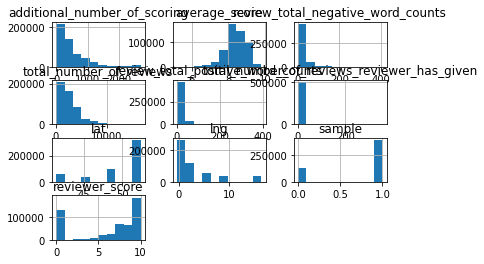

In [226]:
print('\nПостроим распеределение всех возможных признаков быстрой просто визуализацией:\n')
hist = data.hist()
hist

**Ответ:**

* 'additional_number_of_scoring'
* 'average_score'
* 'review_total_negative_word_counts'
* 'total_number_of_reviews'
* 'review_total_positive_word_counts'
* 'total_number_of_reviews_reviewer_has_given'
* 'sample'
* 'reviewer_score'

In [227]:
profile = ProfileReport(df_train, title="Hotels Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# <center> **2. ОЧИСТКА ДАННЫХ**

In [228]:
print("\nАнализ датасет на наличие дублирующихся обзоров :\n")
mask = data.duplicated(subset=data.columns) # маска для фильтрации
data_duplicates = data[mask] # фильтруем наш датасет
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')


Анализ датасет на наличие дублирующихся обзоров :

Число найденных дубликатов: 336



Hаглядная карта пропусков:



<AxesSubplot:>

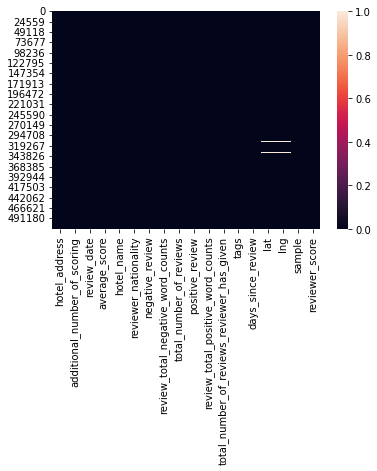

In [229]:
print("\nHаглядная карта пропусков:\n")
sns.heatmap(data.isnull()) 

In [230]:
#создаем копию исходной таблицы
drop_data = data.copy()
#задаем минимальный порог: вычисляем 70% от числа строк
thresh = drop_data.shape[0]*0.7
#удаляем столбцы, в которых более 30% (100-70) пропусков
drop_data = drop_data.dropna(thresh=thresh, axis=1)
#удаляем записи, в которых есть хотя бы 1 пропуск
drop_data = drop_data.dropna(how='any', axis=0)
#отображаем результирующую долю пропусков
drop_data.isnull().mean()

hotel_address                                 0.0
additional_number_of_scoring                  0.0
review_date                                   0.0
average_score                                 0.0
hotel_name                                    0.0
reviewer_nationality                          0.0
negative_review                               0.0
review_total_negative_word_counts             0.0
total_number_of_reviews                       0.0
positive_review                               0.0
review_total_positive_word_counts             0.0
total_number_of_reviews_reviewer_has_given    0.0
tags                                          0.0
days_since_review                             0.0
lat                                           0.0
lng                                           0.0
sample                                        0.0
reviewer_score                                0.0
dtype: float64

# <center> **3. РАЗВЕДЫВАТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ**


Тепловая матрица корреляций:



<AxesSubplot:>

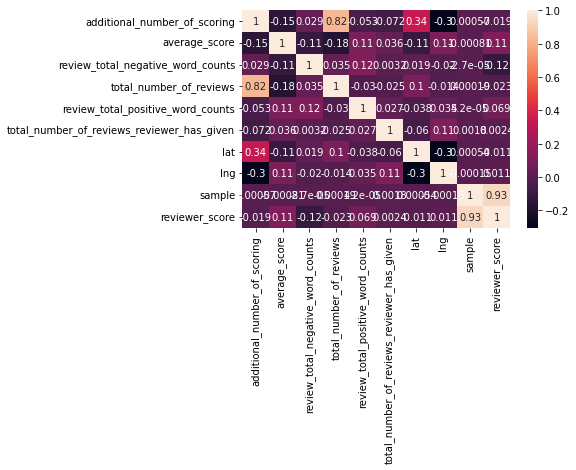

In [231]:
print("\nТепловая матрица корреляций:\n")
sns.heatmap(data.corr(), annot = True)

**Итог:**

* мультиколлинеарность у 0,82 'total_number_of_reviews' и 'additional_number_of_scoring'

* Самая холодная -0,38

print("\nГрафик попарных отношений:\n") 
sns.pairplot(df_train)

# <center> **4. ЭТАП МОДЕЛИРОВАНИЯ**

## <center> **Исследование и проектирование признаков (FEATURE ENGINEERING)**

In [232]:
# даты в понятный для pandas формат
data['review_date'] = pd.to_datetime(data['review_date'])

print("\nКогда были оставлены отзывы min & max:\n")
print(data['review_date'].min(), data['review_date'].max())


Когда были оставлены отзывы min & max:

2015-08-04 00:00:00 2017-08-03 00:00:00


In [233]:
hotels_copy = data

hotels_copy.explode('tags').reset_index(drop= True)
hotels_copy['tags'].iloc[1:10]

1    [' Leisure trip ', ' Group ', ' Triple Room ',...
2    [' Business trip ', ' Solo traveler ', ' Twin ...
3    [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4    [' Business trip ', ' Solo traveler ', ' Class...
5    [' Business trip ', ' Solo traveler ', ' Stand...
6    [' Leisure trip ', ' Couple ', ' Queen Room ',...
7    [' Business trip ', ' Solo traveler ', ' Execu...
8    [' Group ', ' Double or Twin Room ', ' Stayed ...
9    [' Couple ', ' Standard Triple Room ', ' Staye...
Name: tags, dtype: object

In [234]:
print("\nКоличесиво тегов представлено в наборе данных:\n")
def re_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

data['tags_new'] = data['tags'].apply(re_func)
n_tags = data.explode('tags_new')
len(n_tags['tags_new'].unique())


Количесиво тегов представлено в наборе данных:



2428

In [235]:
cnt = coll.Counter() 
for i, row in data['tags'].items():
    tmp = row.replace("[' ", "")
    tmp = tmp.replace(" ']", '')
    tmp = tmp.split(" ', ' ")
    cnt.update(tmp)
print("\nTop-5 tags:\n")    
print(cnt.most_common(5))
print("\nИгформация по tags:\n") 
for key, values in cnt.most_common(25): 
    print(key)


Top-5 tags:

[('Leisure trip', 417778), ('Submitted from a mobile device', 307640), ('Couple', 252294), ('Stayed 1 night', 193645), ('Stayed 2 nights', 133937)]

Игформация по tags:

Leisure trip
Submitted from a mobile device
Couple
Stayed 1 night
Stayed 2 nights
Solo traveler
Stayed 3 nights
Business trip
Group
Family with young children
Stayed 4 nights
Double Room
Standard Double Room
Superior Double Room
Family with older children
Deluxe Double Room
Double or Twin Room
Stayed 5 nights
Standard Double or Twin Room
Classic Double Room
Superior Double or Twin Room
2 rooms
Stayed 6 nights
Standard Twin Room
Single Room


In [236]:
# Введем 3 новых признака из ТОП-3 тэгов
# is_trip (если встречается тэг "Leisure trip")
data['is_trip'] = data['tags'].apply(lambda x: 1 if ('Leisure trip' in x) else 0)
# is_mobile (если встречается тэг "Submitted from a mobile device")
data['is_mobile'] = data['tags'].apply(lambda x: 1 if ('Submitted from a mobile device' in x) else 0)
# is_couple (если встречается тэг "Couple")
data['is_couple'] = data['tags'].apply(lambda x: 1 if ('Couple' in x) else 0)

<AxesSubplot:xlabel='count_nights', ylabel="('count', 'reviewer_score')">

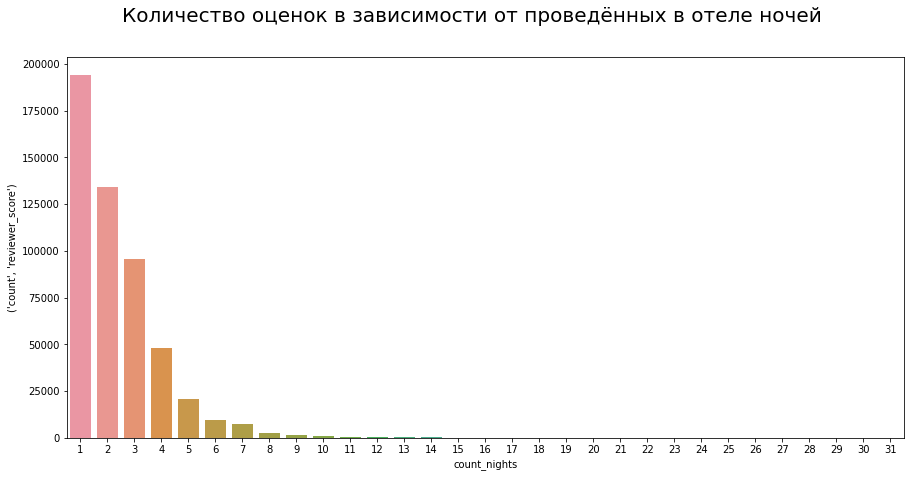

In [237]:
# Введем новый признак count_nights (количество ночей)
def count_nights(tags):
    express = re.findall(r'Stayed\s([0-9]+)\snight', tags)
    return express

data['count_nights'] = data['tags'].apply(count_nights)

def convert(feature):
    for elem, num in enumerate(feature):
        return np.int8(num)
    
data['count_nights'] = data['count_nights'].apply(convert).convert_dtypes().fillna(1)

# Построим график зависимости количества оценок от количества ночей в отели
pivot_nights = pd.pivot_table(
    data=data,
    index='count_nights', 
    values='reviewer_score', 
    aggfunc=['count', 'mean'])
fig1, ax1 = plt.subplots(figsize=(15, 7))
plt.suptitle(
    'Количество оценок в зависимости от проведённых в отеле ночей', size=20)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('count', 'reviewer_score')])

In [238]:
#Кодируем название страны и создаём новый признак
data['reviewer_nationality'] = data['reviewer_nationality'].astype('category')
data['additional_number_of_scoring'] = data['reviewer_nationality'].cat.codes

<AxesSubplot:xlabel='count_nights', ylabel="('count', 'reviewer_score')">

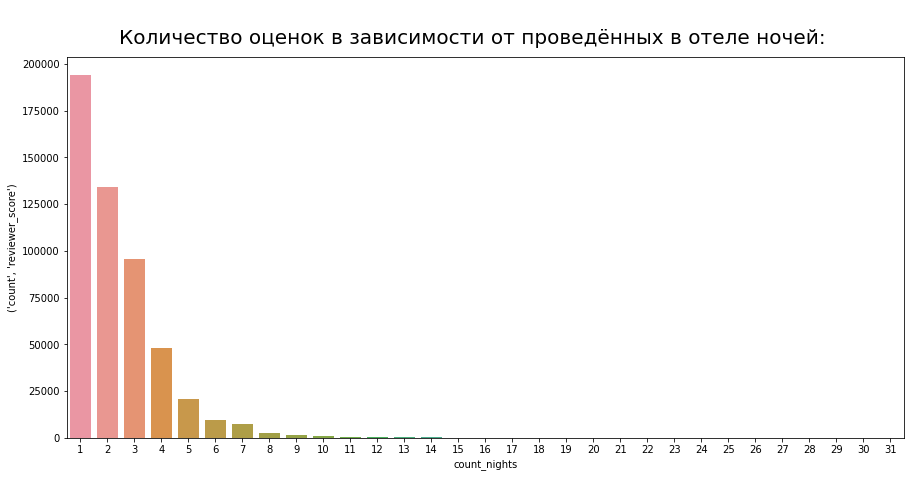

In [239]:
# Введем новый признак count_nights (количество ночей)
def count_nights(tags):
    express = re.findall(r'Stayed\s([0-9]+)\snight', tags)
    return express

data['count_nights'] = data['tags'].apply(count_nights)

def convert(feature):
    for elem, num in enumerate(feature):
        return np.int8(num)
    
data['count_nights'] = data['count_nights'].apply(convert).convert_dtypes().fillna(1)

# Построим график зависимости количества оценок от количества ночей в отели
pivot_nights = pd.pivot_table(
    data=data,
    index='count_nights', 
    values='reviewer_score', 
    aggfunc=['count', 'mean'])
fig1, ax1 = plt.subplots(figsize=(15, 7))
plt.suptitle(
    '\nКоличество оценок в зависимости от проведённых в отеле ночей:\n', size=20)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('count', 'reviewer_score')])

In [240]:
print("\nГражданство рецензента:\n")
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip()) #отсекаем пробелы в начале и в конце строки
print('Рецензенты из {} стран оставили отзывы и оценки об отеле.'.format(data['reviewer_nationality'].nunique()))

# кодируем информацию о стране рецензента:
data['reviewer_nationality'] = data['reviewer_nationality'].astype('category')
data['reviewer_nationality_code'] = data['reviewer_nationality'].cat.codes


Гражданство рецензента:

Рецензенты из 227 стран оставили отзывы и оценки об отеле.


In [241]:
print("\nАнализ дат и сезонности отзывов:\n")
# Представим признак days_since_review в виде числа дней
def count_days(feature):
    count = re.findall(r'\d+', feature)
    return count
    
data['days_since_review'] = data['days_since_review'].apply(count_days)
data['days_since_review'] = data['days_since_review'].apply(convert).convert_dtypes()

# Приведём столбец review_date к типу datetime64:
data['review_date'] = pd.to_datetime(data['review_date'])

# Выделим новый признак: месяц года ("review_month")
data['review_month'] = data['review_date'].dt.month
score_month = data[data['sample']==1].pivot_table(
    values='reviewer_score',
    index='review_month',
    aggfunc='mean'
    )
score_month


Анализ дат и сезонности отзывов:



reviewer_score
review_month                
1                   8.482245
2                   8.534773
3                   8.481505
4                   8.432322
5                   8.385711
6                   8.387010
7                   8.339102
8                   8.412986
9                   8.293349
10                  8.262119
11                  8.343183
12                  8.431444


Pаспределение оценок по месяцам:



(8.0, 8.7)

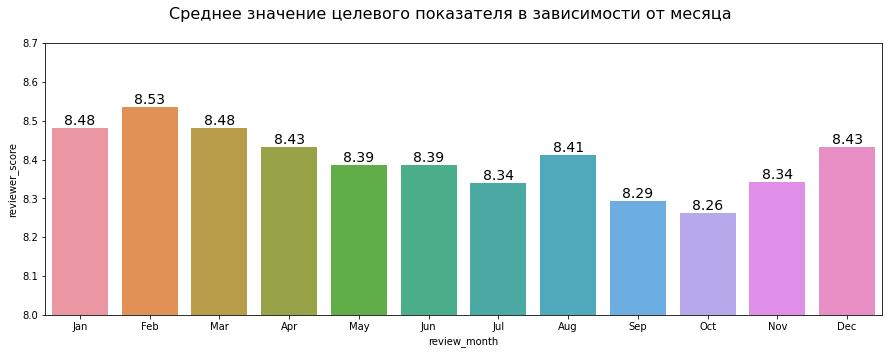

In [242]:
print("\nPаспределение оценок по месяцам:\n")

fig2, ax2 = plt.subplots(figsize=(15, 5))
plt.suptitle('Среднее значение целевого показателя в зависимости от месяца', size=16)
bar_month = sns.barplot(
    x=score_month.index, 
    y=score_month['reviewer_score'])
ax2.set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

for p in bar_month.patches:
    bar_month.annotate(
        '{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(8, 8.7)

In [243]:
print("\nПризнаки стран из адресов отелей:\n")
def country(col):
    res = col.strip().split()
    res = res[-1]
    return res

data['country'] = data['hotel_address'].apply(country)
data['country'].value_counts()


Признаки стран из адресов отелей:



Kingdom        262301
Spain           60149
France          59928
Netherlands     57214
Austria         38939
Italy           37207
Name: country, dtype: int64

In [244]:
def show_corr_heatmap(columns_list, title, method):
    """Построения корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    corr = hotels[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()

# <center> **5. ВЫВОДА МОДЕЛИ В ПРОДАКШЕН**

In [245]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [246]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [247]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [248]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 18), (386803, 18), (386803, 17), (309442, 17), (77361, 17))

In [249]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [250]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [251]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

TypeError: Cannot cast DatetimeArray to dtype float32

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

In [253]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

AttributeError: 'RandomForestRegressor' object has no attribute 'estimators_'

In [254]:
test_data.sample(10)

additional_number_of_scoring review_date  average_score  \
21095                            166  2016-09-22            8.1   
96171                            214  2016-10-31            8.4   
79732                            213  2017-08-02            7.5   
7290                             214  2015-11-10            8.6   
126220                           214  2015-10-15            7.7   
18188                            110  2015-09-03            7.8   
104925                           214  2017-01-05            8.8   
71512                             22  2016-01-19            8.6   
96196                            214  2016-07-30            8.7   
101753                           214  2017-03-07            8.3   

        reviewer_nationality  review_total_negative_word_counts  \
21095                Romania                                 86   
96171         United Kingdom                                  0   
79732   United Arab Emirates                                  0   
7290          United Kingdom                                 31   
126220        United Kingdom                                 30   
18188                 Kosovo                                 45   
104925        United Kingdom                                 11   
71512                Belgium                                  0   
96196         United Kingdom                                  5   
101753        United Kingdom                                 41   

        total_number_of_reviews  review_total_positive_word_counts  \
21095                      3887                                 24   
96171                      1708                                  8   
79732                      2746                                  5   
7290                       4593                                 11   
126220                     1913                                  5   
18188                      5945                                 10   
104925                     1489                                 15   
71512                      1184                                  5   
96196                       363                                  0   
101753                     1023                                 45   

        total_number_of_reviews_reviewer_has_given  days_since_review  \
21095                                           13                 59   
96171                                            1                 20   
79732                                            1                  1   
7290                                             8                120   
126220                                           5               -110   
18188                                            7                -68   
104925                                           1                -46   
71512                                           12                 50   
96196                                            7                113   
101753                                           2               -107   

              lat        lng  reviewer_score  is_trip  is_mobile  is_couple  \
21095   48.158533  16.345112             0.0        1          1          0   
96171   51.494775  -0.177789             0.0        1          1          1   
79732   51.499968  -0.159993             0.0        0          1          0   
7290    52.370247   4.896674             0.0        1          0          1   
126220  51.524145  -0.160991             0.0        1          1          1   
18188   51.499981  -0.192879             0.0        1          0          0   
104925  51.498241  -0.113472             0.0        1          0          1   
71512   48.873207   2.323901             0.0        1          0          1   
96196   51.506159  -0.140280             0.0        1          1          1   
101753  41.396129   2.155163             0.0        1          1          1   

        count_nights  reviewer_nationality_code  review_month  
21095              2   

In [255]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [256]:
sample_submission

reviewer_score      id
0                    1  488440
1                   10  274649
2                    3  374688
3                   10  404352
4                    9  451596
...                ...     ...
128930               7  495812
128931               1  315577
128932               3  511968
128933               6  303386
128934               5  103157

[128935 rows x 2 columns]

In [263]:
predict_submission = model.predict(test_data)

TypeError: Cannot cast DatetimeArray to dtype float32

In [260]:
predict_submission

NameError: name 'predict_submission' is not defined

In [261]:
list(sample_submission)

['reviewer_score', 'id']

In [262]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

NameError: name 'predict_submission' is not defined